In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns

%matplotlib inline

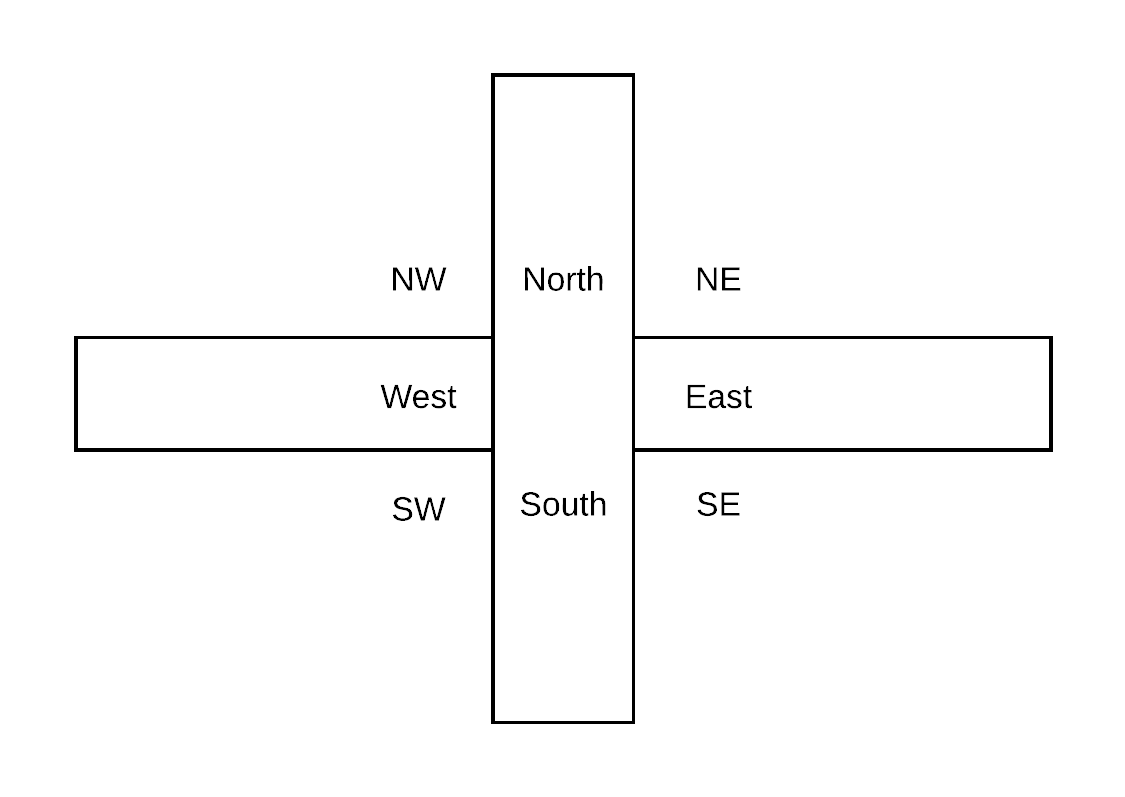

In [2]:
roads = ['north','east', 'south','west' ]
corners = ['NE','NW', 'SW','SE' ]

In [3]:
params= {'cars_per_light_per_period':[7]}

In [4]:
cars = nx.DiGraph()

for r in roads:
    cars.add_node(r)
    
    
for r1 in roads:
    for r2 in roads:
        if r1!=r2:
            cars.add_edge(r1,r2)
            cars.edges[(r1,r2)]['queue'] = 0
            cars.add_edge(r2,r1)
            cars.edges[(r2,r1)]['queue'] = 0

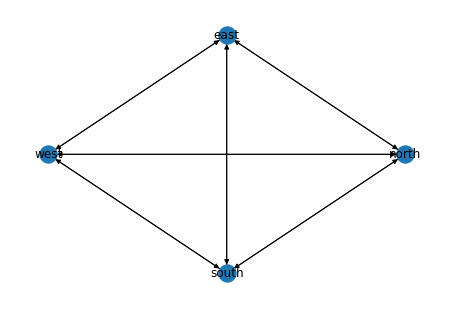

In [5]:
cpos = {'north':[1,0], 'east':[0,1], 'west':[-1,0], 'south':[0,-1]}
nx.draw(cars, cpos, with_labels=True)

In [6]:
pedestrians = nx.DiGraph()

for c in corners:
    pedestrians.add_node(c)

for c1 in corners:
    for c2 in corners:
        if (c1!=c2):
            if (c1[0]==c2[0])or(c1[1]==c2[1]):
                pedestrians.add_edge(c1,c2)
                pedestrians.edges[(c1,c2)]['queue'] = 0
                pedestrians.add_edge(c2,c1)
                pedestrians.edges[(c2,c1)]['queue'] = 0
    

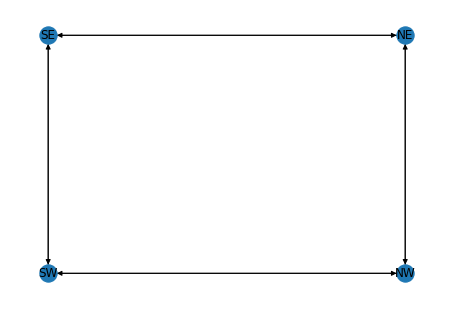

In [7]:
ppos = {'NE':[1,1], 'SE':[-1,1], 'SW':[-1,-1], 'NW':[1,-1]}
nx.draw(pedestrians, ppos, with_labels=True)

In [8]:
#east-west traffic 
A = [('east','west'),
    ('west', 'east'),
    ('NW','NE'),
    ('NE', 'NW'),
    ('SE','SW'),
    ('SW', 'SE')]

#north-south traffic
B = [('south','north'),
    ('north', 'south'),
    ('NW','SW'),
    ('SW', 'NW'),
    ('NE','SE'),
    ('SE', 'NE')]

#south-west, north-east
C = [('south','west'),
    ('west', 'south'),
    ('north','east'),
    ('east', 'north')]

#south-east, north-west
D = [('south','east'),
    ('east', 'south'),
    ('north','west'),
    ('west', 'north')]

In [9]:
def set_lights(pattern_code):
    lights = {}
    for e in cars.edges:
        if e in pattern_code:
            lights[e]=1
        else:
            lights[e] = 0

    for e in pedestrians.edges:
        if e in pattern_code:
            lights[e]=1
        else:
            lights[e] = 0
            
    return lights


In [10]:
#initialize pattern A
lights = set_lights(A)

In [11]:
initial_conditions = {'cars': cars,
                      'pedestrians':pedestrians,
                      'lights':lights
                     }

In [12]:
initial_conditions

{'cars': <networkx.classes.digraph.DiGraph at 0x1a10dff278>,
 'lights': {('NE', 'NW'): 1,
  ('NE', 'SE'): 0,
  ('NW', 'NE'): 1,
  ('NW', 'SW'): 0,
  ('SE', 'NE'): 0,
  ('SE', 'SW'): 1,
  ('SW', 'NW'): 0,
  ('SW', 'SE'): 1,
  ('east', 'north'): 0,
  ('east', 'south'): 0,
  ('east', 'west'): 1,
  ('north', 'east'): 0,
  ('north', 'south'): 0,
  ('north', 'west'): 0,
  ('south', 'east'): 0,
  ('south', 'north'): 0,
  ('south', 'west'): 0,
  ('west', 'east'): 1,
  ('west', 'north'): 0,
  ('west', 'south'): 0},
 'pedestrians': <networkx.classes.digraph.DiGraph at 0x1a10dff748>}

In [13]:
def commuter_arrivals(params, step, sL, s):
    cars = s['cars']
    
    car_arrivals = {e:np.random.randint(0,3) for e in cars.edges}
    
    pedestrians = s['pedestrians']
    
    ped_arrivals = {e:np.random.randint(0,5) for e in pedestrians.edges}
    
    return {'car_arrivals': car_arrivals, 'ped_arrivals':ped_arrivals}

def add_cars(params, step, sL, s, _input):
    
    arrivals = _input['car_arrivals']
    cars = s['cars']    
    
    for e in cars.edges:
        cars.edges[e]['queue'] = cars.edges[e]['queue']+ arrivals[e]
    
    key = 'cars'
    value = cars
    
    return (key, value)

def add_pedestrians(params, step, sL, s, _input):
    
    arrivals = _input['ped_arrivals']
    pedestrians = s['pedestrians']    
    
    for e in pedestrians.edges:
        pedestrians.edges[e]['queue'] = pedestrians.edges[e]['queue']+ arrivals[e]
        
    key = 'pedestrians'
    value = pedestrians
    
    return (key, value)

In [14]:
def light_policy(params, step, sL, s):
    
    options = [A,B,C,D]
    
    step = s['timestep']
    
    pattern = set_lights(options[step % len(options)])
                              
    return ({'pattern':pattern})

def store_light(params, step, sL, s, _input):
    
    pattern = _input['pattern']  
    
    key = 'lights'
    value = pattern
    
    return (key, value)

In [15]:
def commuter_policy(params, step, sL, s):
    
    #follow rules (simple)
    
    commute = [ k for k in s['lights'].keys() if s['lights'][k]==1] 
                              
    return({'commute':commute})

def update_cars(params, step, sL, s, _input):
    
    commute = _input['commute']    
    cars = s['cars']    
    
    rate = params['cars_per_light_per_period']
    
    for e in cars.edges:
        if e in commute:
            cars.edges[e]['queue'] = cars.edges[e]['queue']- rate
            if cars.edges[e]['queue'] <0:
                cars.edges[e]['queue'] = 0
            
    key = 'cars'
    value = cars
    
    return (key, value)

def update_pedestrians(params, step, sL, s, _input):
    
    commute = _input['commute']
    pedestrians = s['pedestrians']    
    
    for e in pedestrians.edges:
        if e in commute:
            pedestrians.edges[e]['queue'] = 0
    
    key = 'pedestrians'
    value = pedestrians
    
    return (key, value)

In [16]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The Partial State Update Blocks
partial_state_update_blocks = [
    {
      'policies': {
          'arrive': commuter_arrivals,
        },
        'variables': {
            'cars': add_cars, 
            'pedestrians': add_pedestrians
        }
    },
    {
      'policies': {
          'set_lights': light_policy,
        },
        'variables': {
            'lights': store_light
        }
    },
    { 'policies': {
          'commute': commuter_policy,
        },
        'variables': {
            'cars': update_cars, 
            'pedestrians': update_pedestrians,
        }
    }
    
]

In [17]:
partial_state_update_blocks

[{'policies': {'arrive': <function __main__.commuter_arrivals>},
  'variables': {'cars': <function __main__.add_cars>,
   'pedestrians': <function __main__.add_pedestrians>}},
 {'policies': {'set_lights': <function __main__.light_policy>},
  'variables': {'lights': <function __main__.store_light>}},
 {'policies': {'commute': <function __main__.commuter_policy>},
  'variables': {'cars': <function __main__.update_cars>,
   'pedestrians': <function __main__.update_pedestrians>}}]

In [18]:
time_periods_per_run = 40
monte_carlo_runs = 1

from cadCAD.configuration.utils import config_sim
simulation_parameters = config_sim({
    'T': range(time_periods_per_run),
    'N': monte_carlo_runs,
    'M': params
})

In [19]:
from cadCAD.configuration import append_configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

[{'N': 1, 'T': range(0, 40), 'M': {'cars_per_light_per_period': 7}}]


In [20]:
from tabulate import tabulate
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs
import pandas as pd

exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=multi_proc_ctx, configs=configs)

In [21]:
i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x1a1305d908>]
Configurations: [<cadCAD.configuration.Configuration object at 0x1a1305d908>]


In [22]:
car_data = results[0]['result'].cars
ped_data = results[0]['result'].pedestrians

In [23]:
data = []
for t in range(time_periods_per_run):
    data_t = {}
    
    cd = car_data[t]
    pdd = ped_data[t]
    for c in cars.nodes:
        data_t[c] = np.sum([cd.edges[e]['queue'] for e in cd.edges if e[0]==c]) 
        
    for p in pedestrians.nodes:
        data_t[p] = np.sum([pdd.edges[e]['queue'] for e in pdd.edges if e[0]==p]) 
        
    data.append(data_t)

In [24]:
df = pd.DataFrame(data)

In [25]:
df.head()

,NE,NW,SE,SW,east,north,south,west
0,0,0,0,0,0,0,0,0
1,6,2,5,5,4,3,3,1
2,6,2,5,5,4,3,3,1
3,4,0,3,2,4,2,1,1
4,10,5,6,8,9,4,5,6


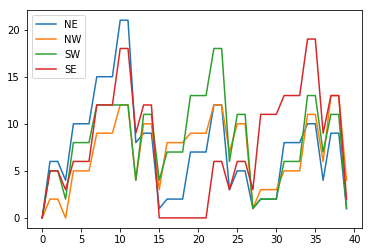

In [26]:
df[corners].plot()

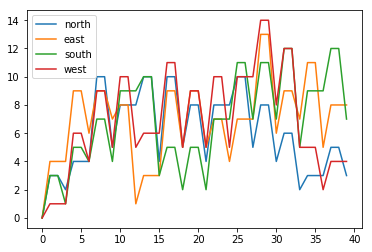

In [27]:
df[roads].plot()